<a href="https://colab.research.google.com/github/Cralsic123/Model-selection-for-abalone-ring/blob/main/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 13.0 MB/s eta 0:00:00


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor


In [3]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c playground-series-s4e4

  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 168MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('/content/playground-series-s4e4.zip', 'r') as zip_ref:
    zip_ref.extractall('./')



In [86]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [54]:
duplicate_rows = train_df[train_df.duplicated()]

In [55]:
duplicate_rows

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings


In [56]:
duplicate_rows = test_df[test_df.duplicated()]

In [57]:
duplicate_rows

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight


In [58]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [59]:
null_values = train_df.isnull().sum()
print(null_values)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64


In [89]:
def map_gender(gender):
    if gender == 'I':
        return 0
    else:
        return 1

train_df['Sex'] = train_df['Sex'].apply(map_gender)
test_df['Sex'] = test_df['Sex'].apply(map_gender)

In [61]:
correlation_matrix = train_df.corr()
correlation_with_rings = correlation_matrix['Rings']
correlation_with_rings = correlation_with_rings.drop('Rings')
most_correlated_column = correlation_with_rings.idxmax()
highest_correlation_value = correlation_with_rings.max()

print(f"The column most correlated with 'Rings' is '{most_correlated_column}' with a correlation coefficient of {highest_correlation_value}.")

The column most correlated with 'Rings' is 'Shell weight' with a correlation coefficient of 0.6947655842875741.


In [62]:
print(correlation_matrix)

                      id       Sex    Length  Diameter    Height  \
id              1.000000  0.005032  0.004724  0.004290  0.005916   
Sex             0.005032  1.000000  0.656415  0.664771  0.645291   
Length          0.004724  0.656415  1.000000  0.989732  0.916094   
Diameter        0.004290  0.664771  0.989732  1.000000  0.919618   
Height          0.005916  0.645291  0.916094  0.919618  1.000000   
Whole weight    0.005228  0.651185  0.931449  0.933848  0.902344   
Whole weight.1  0.004203  0.619272  0.909609  0.908466  0.861769   
Whole weight.2  0.004878  0.646484  0.913134  0.914668  0.886132   
Shell weight    0.005887  0.648101  0.911073  0.917871  0.904019   
Rings           0.000938  0.516591  0.623786  0.636832  0.665772   

                Whole weight  Whole weight.1  Whole weight.2  Shell weight  \
id                  0.005228        0.004203        0.004878      0.005887   
Sex                 0.651185        0.619272        0.646484      0.648101   
Length           

In [63]:
correlation_coefficient = train_df['Sex'].corr(train_df['Rings'])

In [64]:
correlation_coefficient

0.5165910899866304

In [65]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,1,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,0,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,1,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,0,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [76]:
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Detect outliers in numerical columns
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
outliers_dict = {}
for col in numerical_columns:
    outliers_dict[col] = detect_outliers_iqr(train_df[col])

# Print outliers for each numerical column
for col, outliers in outliers_dict.items():
    if not outliers.empty:
        print(f"Outliers in '{col}':")
        print(outliers)
    else:
        print(f"No outliers found in '{col}'.")


No outliers found in 'Sex'.
Outliers in 'Length':
2        0.160
8        0.205
28       0.180
36       0.180
83       0.165
         ...  
90268    0.155
90390    0.160
90445    0.160
90497    0.175
90585    0.175
Name: Length, Length: 1460, dtype: float64
Outliers in 'Diameter':
2        0.110
8        0.150
28       0.110
36       0.125
83       0.125
         ...  
90394    0.150
90398    0.150
90445    0.110
90497    0.130
90585    0.130
Name: Diameter, Length: 1580, dtype: float64
No outliers found in 'Height'.
Outliers in 'Whole weight':
321      2.0320
612      2.0330
1346     2.0370
1778     2.0370
5050     2.0330
5070     2.0330
5264     2.0330
7800     2.0330
8258     2.0320
8261     2.0320
12485    2.0330
13104    2.0330
14287    2.0330
16488    2.0370
18186    2.0330
21572    2.0330
25795    2.0330
27588    2.0330
30750    2.0330
32319    2.0330
32506    2.0330
35092    2.0330
35452    2.0330
39180    2.0320
42884    2.0370
47225    2.0370
47360    2.0370
48505    2.0320
4

In [67]:
train_df.drop(columns = "id",inplace = True)


In [68]:
test_df.drop(columns = "id",inplace = True)

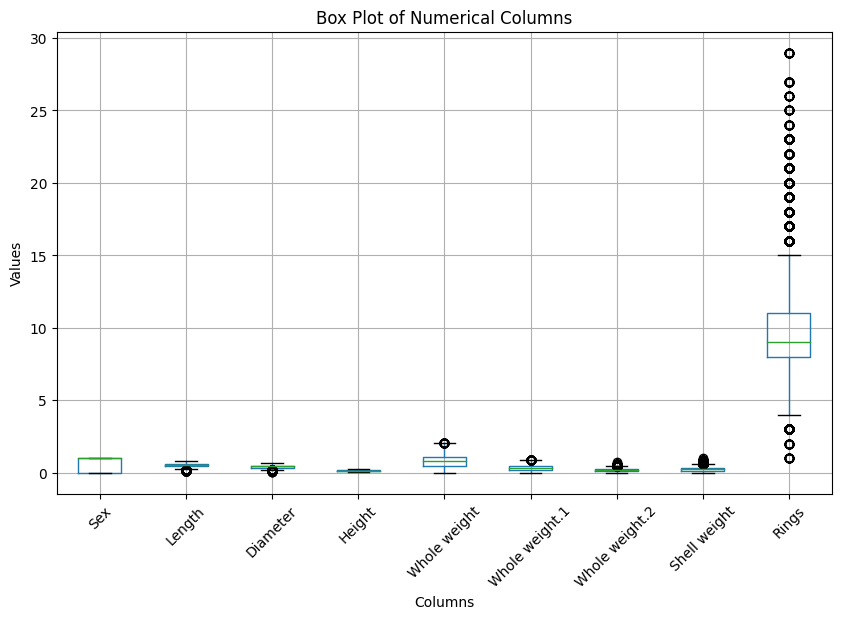

In [77]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns

# Create box plots for each numerical column
plt.figure(figsize=(10, 6))
train_df[numerical_columns].boxplot()
plt.title('Box Plot of Numerical Columns')
plt.xticks(rotation=45)
plt.ylabel('Values')
plt.xlabel('Columns')
plt.show()

In [70]:
def replace_outliers_with_median(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column_without_outliers = column[(column >= lower_bound) & (column <= upper_bound)]
    median_value = column_without_outliers.median()
    column[column < lower_bound] = median_value
    column[column > upper_bound] = median_value
    return column

In [71]:
train_df['Whole weight'] = replace_outliers_with_median(train_df['Whole weight'])

<ipython-input-70-e13704eac2ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
<ipython-input-70-e13704eac2ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value


In [72]:
train_df['Whole weight.1'] = replace_outliers_with_median(train_df['Whole weight.1'])

<ipython-input-70-e13704eac2ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
<ipython-input-70-e13704eac2ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value


In [75]:
train_df['Height'] = replace_outliers_with_median(train_df['Height'])

<ipython-input-70-e13704eac2ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
<ipython-input-70-e13704eac2ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value


In [78]:
train_df['Shell weight'] = replace_outliers_with_median(train_df['Shell weight'])

<ipython-input-70-e13704eac2ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
<ipython-input-70-e13704eac2ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


In [83]:
X = train_df.drop(columns=['Rings'])
y = train_df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42, loss='huber', subsample=0.7, n_estimators=500, max_depth=5, learning_rate=0.1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.2311833890032164


In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [90]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.4644986487897582
